# Variogram fitting

This notebook will illustrate some of features of scipy's optimize module and their effect on variogram estimation.
Given the fact that a variogram is describing a function over distance, that when used in kriging will set observations at large distances to very low weights, the independent variable should not be used unweighted. Second, the independent variable is constrained by the variogram shape and its features.<br>
When using curve_fit from scipy.optimize with standard parameters, it will choose the Levenberg-Marquardt algorithm, which is an algorithm for unconstrained problems. 
Further, the curve_fit function will weight all residuals the same. Both is close to the worst behaviour for variogram fitting.

A little example

In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from skgstat.models import spherical
plt.style.use('ggplot')

In [2]:
# data
y = [2,5,9,14,10,13,9,11,12,14,12,15,13]
x = list(range(len(y)))

# xi used for applying the function
xi = np.linspace(0, len(y), 100)

In [3]:
def f(h, a, b):
    return spherical(h, a, b)

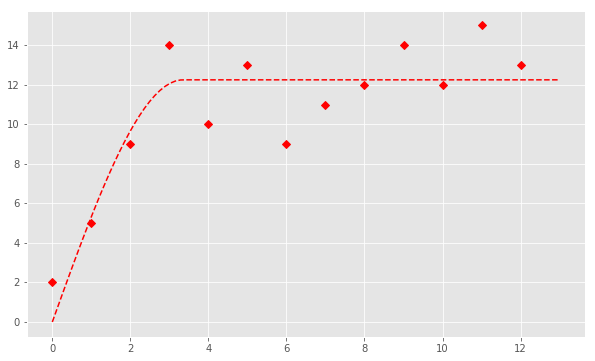

In [4]:
# default parameter
cof, cov = curve_fit(f, x, y)
yi = list(map(lambda x: spherical(x, *cof), xi))

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD')
ax.plot(xi, yi, '--r')

## parameter space

That fitting went well, because I chose an experimental variogram that can be fitted quite well by Levenberg-Marquardt. But it is an unconstrained procedure, which means the parameter space for each variable is unlimited and independent. We know, that an experimental variogram will always be located in the first quadrant as a separating distance will always be positive. The semi-variance is defined to be positive (or 0). Therefore the three variogram parameters have to be positive as well.<br>
The problem with an unconstrained fitting is that the procedure might try values *in the wrong direction* and then fail to find a good guess before it reaches its iteration limit.

With just a few changes to the y array, this becomes obviuous.

/home/mirko/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


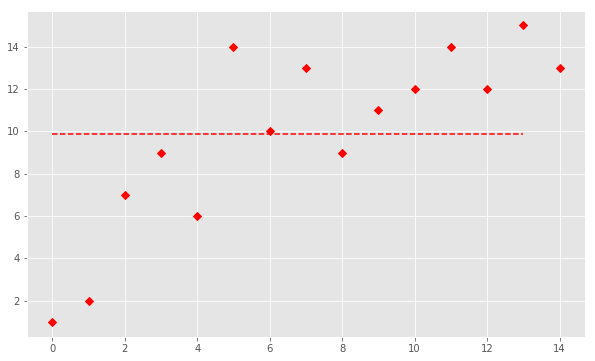

In [5]:
y = [1,2,7,9,6,14,10,13,9,11,12,14,12,15,13]
x = list(range(len(y)))

# default parameter
cof, cov = curve_fit(f, x, y)
yi = list(map(lambda x: spherical(x, *cof), xi))

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD')
ax.plot(xi, yi, '--r')

We can at least make the fitting work again by switching to an constrained case (and procedure). scipy will change from the *leastsq* function used so far to the *least_squares* function. Seems to be similar, but *leastsq* is the Levenberg-Marquardt, while *least_squares* implements two box constrained methods. Box constrained in this context means you define a upper and lower bound of a region, which the two algorithms will search for the best parameter set. You will also need an initial guess<br>
In the case of variogram fitting this is quite easy, as we know that the lower bound of all parameters is 0. In case of the sill, a value higher than the maximum observed empirical semi-variance doesn't make any sense. The nugget cannot be higher than the sill. For the range, the maximum can be set to the last bins upper bound. This will make the fitting significantly more robust and the function should not fail in searching for parameters as you put its nose on it.

We can also justify y again, to make the default fitting work again

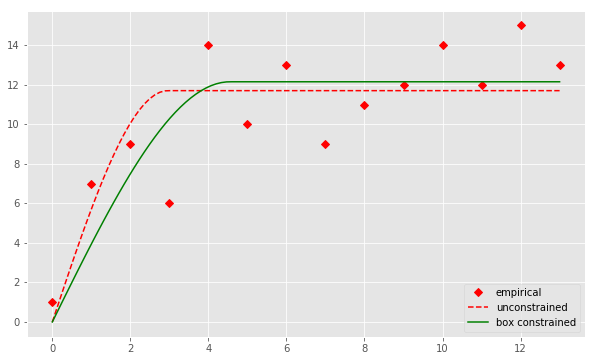

In [6]:
y = [1,7,9,6,14,10,13,9,11,12,14,12,15,13]
x = list(range(len(y)))

# default parameter
cof, cov = curve_fit(f, x, y)
yi_d = list(map(lambda x: spherical(x, *cof), xi))

# box constrained fit
#                             first guess    lower bound     upper bounds  
cof, cov = curve_fit(f, x, y, p0=[3., 14.], bounds=(0, (np.max(x), np.max(y))))
yi_b = list(map(lambda x: spherical(x, *cof), xi))

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD', label='empirical')
ax.plot(xi, yi_d, '--r', label='unconstrained')
ax.plot(xi, yi_b, '-g', label='box constrained')
ax.legend(loc='lower right')

### on the influence of initial guess

You might wonder, that the new fit looks worse on the first points. Well, keep in mind, that the unconstrained procedure just guesses something. There is no control about that. Therefore, setting a initial guess is the cleaner way, but, of course, you can make a bad guess. look at this:

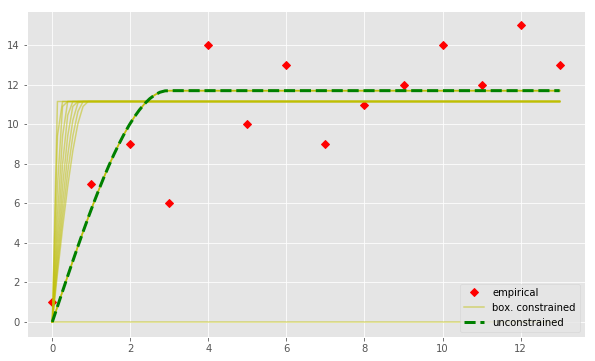

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD', label='empirical')


for p in zip(np.arange(0, 5., 0.1), [0.] * len(x)):
    cof, cov = curve_fit(f, x, y, p0=p, bounds=(0, (np.max(x), np.max(y))))
    if p[0] == 0:
        ax.plot(xi, list(map(lambda x: spherical(x, *cof), xi)), '-y', alpha=0.5, label='box. constrained')
    else:
        ax.plot(xi, list(map(lambda x: spherical(x, *cof), xi)), '-y', alpha=0.5)
   
ax.plot(xi, yi_d, '--g', label='unconstrained', lw=3)
ax.legend(loc='lower right')

# Fit by weight 

The *curve_fit* function can weight the observations for fitting. This attribute to * curve_fit* is not very obvious. You can declare an array of sigma values, which are referred to as uncertainty of the dependent variable. The scipy documentation suggests to use the standard deviation here. Although it could easily be calculated for a variogram, this is not how we will use sigma. It is impllemented in the loss function as 
$$ chisq = \sum {\left( \frac{r}{\sigma} \right)}^2$$
where $r$ are the residuals of the modeled observations. Therefore, in fact by setting large values to $\sigma$, we can decrease the influence of that observation for the fitting. 

For the variogram, as already menmtioned, the model will be used to derive kriging weights. Smaller function values will result in heigher kriging weights. This also implies, that residuals, if understood as errors, will propagate into the kriging. Model values close to the sill will have almost no effect on the overall result, while the first few points and their residuals will have the highest impact. Now, instead of just ignoring the few last points in the fitting, we can just double the impact of the first few points. By setting 
$$ \sigma_{1:7} := \frac{1}{2} $$<br>
$$\sigma_{8:14} := 1.$$
This will lead to a doubled weights on the first 7 points.

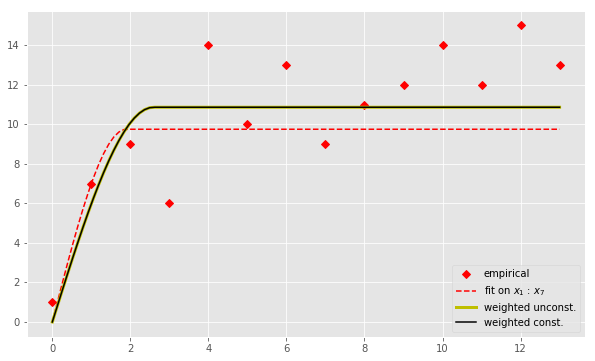

In [8]:
# default parameters, completely ignoring the last points
cof, cov = curve_fit(f, x[:6], y[:6])
yi_n = list(map(lambda x: spherical(x, *cof), xi))

# set weights
sigma = np.ones(len(y))
sigma[:6] *= 0.5

#unconstrained weighted
cof, cov = curve_fit(f, x, y, sigma=sigma)
yi_w = list(map(lambda x: spherical(x, *cof), xi))

# constrained weighted
cof, cov = curve_fit(f, x, y, p0=[3., 14.], bounds=(0, (np.max(x), np.max(y))), sigma=sigma)
yi_cw = list(map(lambda x: spherical(x, *cof), xi))

# plot
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD', label='empirical')
ax.plot(xi, yi_n, '--r', label='fit on $x_1$ : $x_7$')
ax.plot(xi, yi_w, '-y', label='weighted unconst.', lw=3)
ax.plot(xi, yi_cw, '-k', label='weighted const.')
ax.legend(loc='lower right')

Two things become obvious here. First, in this presented example, the unconstrained and constrained weighted fitting procedures find exactly the same parameters. And second, just neglecting the last points for fitting will lead to a significantly lower sill. The nice thing about the sigma is, that as soon as it is clear how it is implemented, we can utilize this *'uncertainty'* to come up with very individual solutions of how to weight the observations.

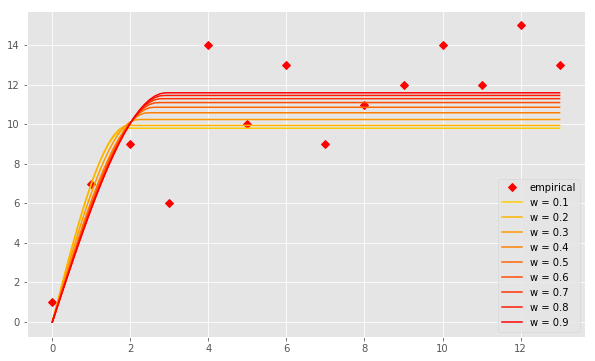

In [9]:
from matplotlib.cm import get_cmap
cm = get_cmap('autumn_r')

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD', label='empirical')

sigma = np.ones(len(x))

for w in np.arange(0.1, 1., .1):
    s = sigma.copy()
    s[:6] *= w
    
    cof, cov = curve_fit(f, x,y, sigma=s)
    ax.plot(xi, list(map(lambda x: spherical(x, *cof), xi)), linestyle='-', color=cm(w + 0.1), label='w = %.1f' % w)

ax.legend(loc='lower right')

The w-parameter is used as a weight to the first 7 points. Here, 0.9 is closest to the unweighted case, where w would be 1. Following the loss function formula, w=0.1 would result in:
$$chisq_{w=0.1;x_{1:7}} = \sum (10r)^2$$
for $x_1, x_2, ... x_7$ and 
$$chisq_{w=1.;x_{8:14}} = \sum r^2$$
You can see how incresing the weight on the first 7 points lowers the sill and pronounces the first points more. 

### Fit by distance

Instead of setting the weights by hand, a function of separating distance can be defined. This is particular helpfull as it ensures smaller residuals at short distances and larger residuals at far distances. But as no point outside the range will be used for interpolation, all residuals outside the range do not matter.<br>
The next example defines six different functions for finding the weights $w(x)$ as a function of separating distance $x$:
$$ w_n (x) = \frac{x}{max(x)} $$<br>
$$ w_e (x) = e^{\frac{1}{w_n}}$$<br>
$$ x_{sqrt} (x) = \sqrt{w_n} $$<br>
$$ x_p (x) = {w_n}^2 $$<br>
$$ x_c (x) = {w_n}^3 $$<br>
$$ x_q (x) = {w_n}^4 $$<br>

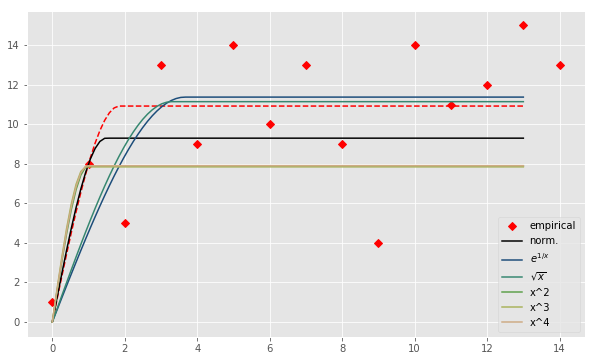

In [17]:
# make it a bit more difficult
y = [1,8,5,13,9,14,10,13,9,4,14,11,12,15,13]
x = list(range(len(y)))

cm = get_cmap('gist_earth')
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'rD', label='empirical')
cof, cov = curve_fit(f, x, y)
ax.plot(xi, list(map(lambda x: spherical(x, *cof), xi)), '--r')

# increase the distance by 1 to avoid zeros
X = np.asarray([(_ + 1) for _ in x])

s1 = X / np.max(X)
s2 = np.exp(1. / X)
s3 = np.sqrt(s1)
s4 = s1**2
s5 = s1**3
s6 = s1**4

for i, s in enumerate(zip((s1,s2,s3,s4,s5,s6), ('norm.', '$e^{1/x}$', '$\sqrt{x}$', 'x^2', 'x^3', 'x^4'))):
    cof, cov = curve_fit(f, x, y, sigma=s[0], p0=[6., 14.], bounds=(0,(14. ,14.)))
    ax.plot(xi, list(map(lambda x: spherical(x, *cof), xi)), linestyle='-', color=cm((i / 6)), label=s[1]) 
ax.legend(loc='lower right')

The three exponential function produce similar reuslts in the given example. All of them are only determined by the first two observations as the loss function for weights is dropping really fast. The normalized distances (to their maximum value) produce a slightly higher sill, but are also only determined by the first two points.<br>
In the given example, the two box-constrained fits defining a e- and squareroot dependency of fitting weights on the distance yield the most reasonable variograms. The dashed red line is the unconstrained, unweighted fit. The e and sqrt functions yield a comparable sill, while reflecting the residuals for close distances better. This will result in a more robust kriging interpolation.